In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns

In [2]:
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path='/content/drive/MyDrive/ Image_captioning/ text_dataset/Flickr8k_text/Flickr8k.token.txt'
with open(path) as f:
    lines=f.readlines()

In [5]:
#seperating images and text discriptions
image=[];text=[]
for i in lines:
    image_= i.split("\t")[0]
    image_= re.sub("#[0-9]","",image_)
    image.append(image_)
    text_= i.split("\t")[1]
    text_ = re.sub(" .\n","",text_)
    text.append(text_)

In [6]:
d={'image':image,'text':text}
df = pd.DataFrame(d, columns = ['image','text'], index=[i for i in range(len(image))])
df.head(5)

,image,text
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
def preprocess_english(text):
    sent=decontractions(text)
    sent=re.sub(r"-","  ",sent)
    sent=re.sub(r'[^A-Za-z ]',"",sent)
    sent = ' '.join(e.lower() for e in sent.split() if len(e)>1)
    return sent

In [9]:
df['processed_text']=df['text'].apply(preprocess_english)

def find_length(sentence):
    return len(sentence.split())
df['len_processed_text'] = df['processed_text'].apply(find_length)

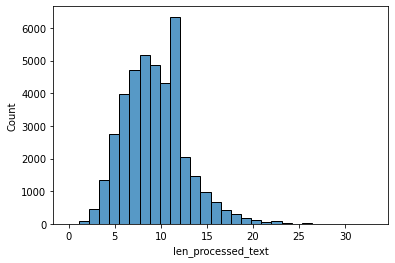

In [10]:
sns.histplot(df['len_processed_text'],bins=30)

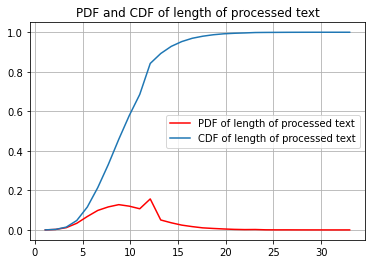

In [11]:
count, bins_count = np.histogram(df['len_processed_text'], bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

plt.title('PDF and CDF of length of processed text')
plt.plot(bins_count[1:], pdf, color="red", label="PDF of length of processed text")
plt.plot(bins_count[1:], cdf, label="CDF of length of processed text")
plt.legend()
plt.grid()

In [12]:
max_len = int(np.percentile(df['len_processed_text'],95))
max_len

15

## Observation 

Most of the discriptions have length less than  20. We can choose suitable percentile range to avoid few lengthy discriptions.

In [13]:
df=df[df['len_processed_text']<=max_len] #data set after consideringonly sentances with length less than max_len
df.shape

(38549, 4)

In [14]:
image_list=list(df['image'])
len(image_list)

38549

In [15]:
image_set=set(image_list) #all images
len(image_set)

8092

In [16]:
d={}
for i in image_set:
    d[i]=image_list.count(i)

In [17]:
#images and count of discriptions
for i,j in d.items():
    if j<=2:
        print(i,"--",j)

3471571540_b4ab77f20d.jpg -- 2
3345025842_bc2082a509.jpg -- 2
3256274183_4eab3b2322.jpg -- 2
1470536919_1f3fd6c65a.jpg -- 2
3191982761_88793192ed.jpg -- 2
2731171552_4a808c7d5a.jpg -- 1
3327563443_870a33f748.jpg -- 2
3229821595_77ace81c6b.jpg -- 2
2354456107_bf5c766a05.jpg -- 2
972381743_5677b420ab.jpg -- 2
2831215155_07ba8f1805.jpg -- 2
532457586_bddfc5251d.jpg -- 2
2127207912_9298824e66.jpg -- 2
3331525712_af1dcc47f2.jpg -- 2
2504764590_cf017c2a6e.jpg -- 2
2689001252_e0016c89f0.jpg -- 2
133189853_811de6ab2a.jpg -- 2
2600386812_8790879d9a.jpg -- 2
1303548017_47de590273.jpg -- 2
2273591668_069dcb4641.jpg -- 2
3411393875_a9ff73c67a.jpg -- 2
2309860995_c2e2a0feeb.jpg -- 2
2894217628_f1a4153dca.jpg -- 2
2826769554_85c90864c9.jpg -- 2
3082196097_2d15455b00.jpg -- 2
3471841031_a949645ba8.jpg -- 2


## Observation

Even though the max length of processed text is terminated to 15, all the images are present and very few images have discription count of 2 or less than 2 

In [18]:
df['input']='<start> '+df['processed_text']+' <end>'
df['output']= df['processed_text']+' <end>'+' <end>'

In [19]:
print(df.shape)
df.head(5)

(38549, 6)


,image,text,processed_text,len_processed_text,input,output
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,child in pink dress is climbing up set of stai...,14,<start> child in pink dress is climbing up set...,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building,girl going into wooden building,5,<start> girl going into wooden building <end>,girl going into wooden building <end> <end>
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse,little girl climbing into wooden playhouse,6,<start> little girl climbing into wooden playh...,little girl climbing into wooden playhouse <en...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,little girl climbing the stairs to her playhouse,8,<start> little girl climbing the stairs to her...,little girl climbing the stairs to her playhou...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,little girl in pink dress going into wooden cabin,9,<start> little girl in pink dress going into w...,little girl in pink dress going into wooden ca...


In [20]:
df=df[['image','input','output']] #storing required columns after preprocessing
df.to_csv('/content/drive/MyDrive/ Image_captioning/data.csv',index=False)

In [21]:
df_p=pd.read_csv('/content/drive/MyDrive/ Image_captioning/data.csv')
print(df_p.shape)
df_p.head()

(38549, 3)


,image,input,output
0,1000268201_693b08cb0e.jpg,<start> child in pink dress is climbing up set...,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,<start> girl going into wooden building <end>,girl going into wooden building <end> <end>
2,1000268201_693b08cb0e.jpg,<start> little girl climbing into wooden playh...,little girl climbing into wooden playhouse <en...
3,1000268201_693b08cb0e.jpg,<start> little girl climbing the stairs to her...,little girl climbing the stairs to her playhou...
4,1000268201_693b08cb0e.jpg,<start> little girl in pink dress going into w...,little girl in pink dress going into wooden ca...


In [22]:
path='/content/drive/MyDrive/ Image_captioning/ image_dataset/Flicker8k_Dataset'

In [23]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        images_list=[];features_list=[] 
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            images_list.append(img)
            features_list.append(feature[0])
        return  images_list,features_list 

#2048 feature vector
images_list,features_list = extract_features(path)

100%|██████████| 8091/8091 [50:40<00:00,  2.66it/s]


In [24]:
pickle.dump((images_list,features_list),open('/content/drive/MyDrive/ Image_captioning/image_and_feature_1.pkl','wb'))